# PyTorch로 MNIST 숫자 이미지 분류하기
이 노트북에서는 PyTorch를 사용하여 손글씨 숫자(MNIST) 이미지를 분류하는 간단한 CNN 모델을 구현합니다.

# 1. 라이브러리 임포트 및 환경 설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('사용 디바이스:', device)


print('CUDA 사용 가능 여부:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA 디바이스 이름:', torch.cuda.get_device_name(0))

사용 디바이스: cuda
CUDA 사용 가능 여부: True
CUDA 디바이스 이름: NVIDIA GeForce RTX 2080 SUPER


## 2. 데이터셋 준비 및 DataLoader 생성

In [2]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3. 모델 정의 (간단한 CNN)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

## 4. 손실 함수 및 옵티마이저 설정

In [4]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 5. 모델 학습

In [5]:
epochs = 5
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} 완료")

Epoch 1/5 완료
Epoch 2/5 완료
Epoch 3/5 완료
Epoch 4/5 완료
Epoch 5/5 완료


## 6. 모델 평가 (정확도 측정)

In [6]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f"테스트 정확도: {100 * correct / total:.2f}%")

테스트 정확도: 98.84%


## 7. 예측 결과 시각화

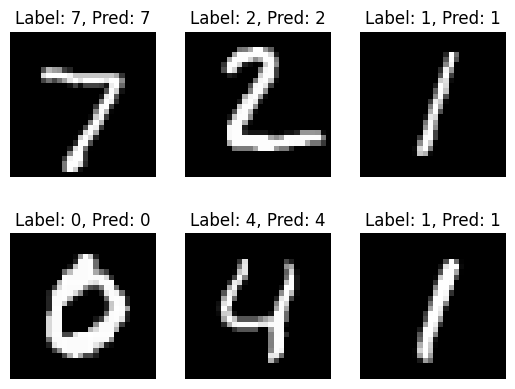

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model(example_data.to(device))
    preds = output.argmax(dim=1, keepdim=True)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i]}, Pred: {preds[i].item()}")
    plt.axis('off')
plt.show()